# 【研报复现】蜘蛛网策略

本报告根据高子剑和魏建榕的系列研报进行复现，有：

20131231-东方证券-股指期货趋势交易之＂蜘蛛网策略＂：从成交持仓表中捕捉知情投资者行为

20160907-方正证券-持仓量的奥义：从交易行为到 CTA 策略

20170412-方正证券-CTA专题研究：蜘蛛网爱国债期货

20170501-方正证券-CTA专题研究：蜘蛛网拥抱商品期货

20170722-方正证券-国债期货蜘蛛网策略绩效回顾

20170815-方正证券-蜘蛛网研究心得第1期：最美CTA信号

20170828-方正证券-蜘蛛网研究心得第2期：择时对冲的潜力

20170904-方正证券-蜘蛛网研究心得第3期：ETF择时

20170919-方正证券-蜘蛛网研究心得第4期：短暂的玫瑰

20180404-东吴证券-CTA策略专题：蜘蛛网研究心得，信号的精炼

这个策略的优点是没有用任何参数，仅使用了交易所每天公开发布的前20名结算会员成交持仓排名列表，对策略感兴趣的可以看原报告。

#### 一、策略思路

期货投资者的交易行为，包含了他们对市场走势的看法与预期，并最终必然反映到成交量与持仓量的变化之中。

假设聪明的投资者相比一般投资者有着更专业的投资水平，他们有着对市场更好的预测能力，如果他们有相比更大的资金去进行交易，那么他们的交易行为将被反馈到成交量上，而一般投资者的投资在多空持仓上体现则更为随机，因此其总体持仓水平无法在持仓量上得到体现。

交易所对每天单边持仓达到1万手以上（含）和当月合约前20名结算会员的成交量、持仓量进行公布。

成交持仓排名列表长这个样子：
![image](http://chuantu.biz/t6/350/1532883536x1822611263.png)

从列表里可以得到前二十排名的持仓数和增减，在接近换约的时候有时会公布多个合约的排名，那么需要把多个表合并。最终得出前二十位会员合计的多头持仓量变化和空头持仓量变化。

蜘蛛网策略的基本规则很简单，每天统计前二十位会员合计的多头及空头持仓量变化：

若多单增加且空单减少，发出看多的信号；若多单减少且空单增加，则发出看空的信号；多单与空单同向增减时，不发信号。

该策略意味着假设前二十名会员增持多头而减持空头，则表示大资金的聪明投资者对多头有一致预期，那么第二天的多头走势可能会延续，反之亦然。如果多空持仓变化皆同增或同减，则暂时没有一致预期，那么应该空仓。

#### 二、准备样本及回测

虽然可以通过爬虫对交易所公布的数据进行下载，不过这个方法比较麻烦，万德的数据库提供了历史成交持仓数据，目前可以通过万德旗下的windquant平台获得，具体可以通过wset的api对futureoir字段进行查询，这里我整理了5个金融期货品种的从上市以来到20180720的历史成交持仓数据，可供回测。

In [1]:
import pandas as pd
df = pd.read_excel('IF_oir.xls')
df.head()

,date,ranks,member_name,long_position,long_position_increase,long_potion_rate,short_position,short_position_increase,short_position_rate,net_long_position,net_long_position_increase,net_short_position,net_short_position_increase,net_position_rate,vol,vol_increase,vol_rate,settle
0,2018-07-20,NaN,前二十名合计,29627,207,60.085584,34756,642,70.487548,NaN,NaN,5129.0,435.0,10.401963,49857,6507,62.076050,3478.8
1,2018-07-19,NaN,前二十名合计,31731,-248,62.414682,35699,347,70.219713,NaN,NaN,3968.0,595.0,7.805032,45426,4552,62.357237,3426.8
2,2018-07-18,NaN,前二十名合计,31974,-237,62.165105,36284,-689,70.544776,NaN,NaN,4310.0,-452.0,8.379671,41343,-1015,61.227119,3430.4
3,2018-07-17,NaN,前二十名合计,26300,-1354,50.565254,30069,-1113,57.811659,NaN,NaN,3769.0,241.0,7.246405,35675,4820,52.865949,3430.4
4,2018-07-16,NaN,前二十名合计,27386,116,54.187855,31202,-62,61.738459,NaN,NaN,3816.0,-178.0,7.550604,31170,3895,56.767684,3457.4


对5个金融期货的主力合约分别回测近3年的行情，以账户1000000做1手的比例，策略规则如下：

long and cover in open_price if last_tradeday long_position_increase > 0 and short_position_increase < 0 

short and sell in open_price if last_tradeday long_position_increase < 0 and short_position_increase > 0 

else sell or cover in open_price

In [2]:
from rqalpha_plus.api import *
#以上操作会导致当前数据获取API被覆盖，所以在运行完毕之后需要通过 from rqdatac import * 的方式恢复
from rqalpha_plus import run_func, run_code

config = {
  "base": {
    "matching_type": "next_bar",
    "start_date": "2015-07-01", # 回测开始日期
    "end_date": "2018-06-29", # 回测结束日期
    "frequency": '1m', # 回测频率, 分钟: '1m'
    "accounts": {"future":1000000} # 期货账户
  },
  "mod": {
    "sys_progress": {"enabled": True,"show": True,},
    "sys_analyser": {"enabled": True,},
  }
}

In [3]:
import datetime

In [4]:
# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init_IF(context):
    context.df_oir = read_oir('IF_oir.xls')
    context.hold = 0
    context.future_id = 'IF88'
    subscribe(context.future_id)
    context.signal = 0
    context.lots = 1
    
def init_IC(context):
    context.df_oir = read_oir('IC_oir.xls')
    context.hold = 0
    context.future_id = 'IC88'
    subscribe(context.future_id)
    context.signal = 0
    context.lots = 1
    
def init_IH(context):
    context.df_oir = read_oir('IH_oir.xls')
    context.hold = 0
    context.future_id = 'IH88'
    subscribe(context.future_id)
    context.signal = 0
    context.lots = 1
    
def init_T(context):
    context.df_oir = read_oir('T_oir.xls')
    context.hold = 0
    context.future_id = 'T88'
    subscribe(context.future_id)
    context.signal = 0
    context.lots = 1
    
def init_TF(context):
    context.df_oir = read_oir('TF_oir.xls')
    context.hold = 0
    context.future_id = 'TF88'
    subscribe(context.future_id)
    context.signal = 0
    context.lots = 1

In [5]:
# before_trading此函数会在每天策略交易开始前被调用，当天只会被调用一次
def before_trading(context):
    pass

# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def handle_bar(context, bar_dict):
    if context.now.time() == datetime.time(9,31):
        # 查询目前持仓
        if context.portfolio.positions[context.future_id].market_value > 0:
            context.hold = 1
        elif context.portfolio.positions[context.future_id].market_value < 0:
            context.hold = -1
        elif context.portfolio.positions[context.future_id].market_value == 0:
            context.hold = 0
    
        # 根据信号进行买卖，有反向持仓则先平仓
        if context.signal == 1 and context.hold == 0:
            buy_open(context.future_id, amount = context.lots) 
        elif context.signal == 1 and context.hold == -1:
            buy_close(context.future_id, amount = context.lots)
            buy_open(context.future_id, amount = context.lots)
    
        elif context.signal == 0 and context.hold == 1:
            sell_close(context.future_id, amount = context.lots)
        elif context.signal == 0 and context.hold == -1:
            buy_close(context.future_id, amount = context.lots)
    
        elif context.signal == -1 and context.hold == 0:
            sell_open(context.future_id, amount = context.lots)
        elif context.signal == -1 and context.hold == 1:
            sell_close(context.future_id, amount = context.lots)
            sell_open(context.future_id, amount = context.lots)

# after_trading函数会在每天交易结束后被调用，当天只会被调用一次
def after_trading(context):
    # 每天收盘获取信号，在下一个交易日使用
    trade_date = context.now.date()
    context.signal = context.df_oir[context.df_oir['date'] == trade_date].signal.values[0]

# 读取回测用持仓数据，根据数据计算信号
def read_oir(filename):
    df = pd.read_excel(filename)
    df = df.sort_values('date',ascending=True)
    df['date'] = df['date'].map(lambda x:x.date())
    df.index = pd.DatetimeIndex(df['date'])
    df.index.name = None
    
    signal = []
    # 1：多头，-1：空头，0：空仓
    for index, row in df.iterrows():
        if row['long_position_increase'] > 0 and row['short_position_increase'] < 0:
            signal.append(1)
        elif row['long_position_increase'] < 0 and row['short_position_increase'] > 0:
            signal.append(-1)
        else:
            signal.append(0)
            
    df['signal'] = signal
    return df

In [7]:
result_IF = run_func(init=init_IF, handle_bar=handle_bar, before_trading=before_trading, after_trading=after_trading, config=config)

[2018-07-30 22:44:17.777649] INFO: system_log: rqdatac use socket ('192.168.0.241', 16003)


/opt/conda/envs/ricequant/lib/python3.5/site-packages/rqalpha/utils/risk.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self._beta = cov[0][1] / cov[1][1]


In [8]:
result_IC = run_func(init=init_IC, handle_bar=handle_bar, before_trading=before_trading, after_trading=after_trading, config=config)

[2018-07-30 22:44:26.211391] INFO: system_log: rqdatac use socket ('192.168.0.241', 16003)


2016-01-05 09:31:00.000000 WARN 订单被拒单: [IC88] 已跌停。
/opt/conda/envs/ricequant/lib/python3.5/site-packages/rqalpha/utils/risk.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self._beta = cov[0][1] / cov[1][1]


In [9]:
result_IH = run_func(init=init_IH, handle_bar=handle_bar, before_trading=before_trading, after_trading=after_trading, config=config)

[2018-07-30 22:44:33.826397] INFO: system_log: rqdatac use socket ('192.168.0.241', 16003)


/opt/conda/envs/ricequant/lib/python3.5/site-packages/rqalpha/utils/risk.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self._beta = cov[0][1] / cov[1][1]


In [10]:
result_T = run_func(init=init_T, handle_bar=handle_bar, before_trading=before_trading, after_trading=after_trading, config=config)

[2018-07-30 22:44:42.006114] INFO: system_log: rqdatac use socket ('192.168.0.241', 16003)


2015-08-13 09:31:00.000000 WARN Order Cancelled: market order T88 volume 1 due to volume limit
/opt/conda/envs/ricequant/lib/python3.5/site-packages/rqalpha/utils/risk.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self._beta = cov[0][1] / cov[1][1]


In [11]:
result_TF = run_func(init=init_TF, handle_bar=handle_bar, before_trading=before_trading, after_trading=after_trading, config=config)

[2018-07-30 22:44:51.400813] INFO: system_log: rqdatac use socket ('192.168.0.241', 16003)


/opt/conda/envs/ricequant/lib/python3.5/site-packages/rqalpha/utils/risk.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self._beta = cov[0][1] / cov[1][1]


In [12]:
def analyze_result(result):
    result['sys_analyser']['portfolio']['unit_net_value'].plot(legend='unit_net_value', figsize = (12,8))
    plt.show()
    # 统计交易胜率
    df = result['sys_analyser']['trades']
    wins = 0
    if len(df) % 2 == 0:
        length = len(df)
    else:
        length = len(df) - 1
    for j in range(0, length, 2):
        if ((df.ix[j+1]['last_price'] - df.ix[j]['last_price']) > 0) and df.ix[j]['side'] == 'BUY':
            wins = wins + 1
        elif ((df.ix[j+1]['last_price'] - df.ix[j]['last_price']) < 0) and df.ix[j]['side'] == 'SELL':
            wins = wins + 1
    win_rate = round(2 * wins/len(df), 3)
    
    print('交易品种：{}'.format(result['sys_analyser']['trades'].ix[0]['order_book_id']))
    print('总收益率：{:%}'.format(result['sys_analyser']['summary']['total_returns']))
    print('年化收益率：{:%}'.format(result['sys_analyser']['summary']['annualized_returns']))
    print('最大回撤：{:%}'.format(result['sys_analyser']['summary']['max_drawdown']))
    print('夏普比率：{:.3f}'.format(result['sys_analyser']['summary']['sharpe']))
    print('信息比率：{:.3f}'.format(result['sys_analyser']['summary']['information_ratio']))
    print('波动率：{:.3f}'.format(result['sys_analyser']['summary']['volatility']))
    print('跟踪误差：{:.3f}'.format(result['sys_analyser']['summary']['tracking_error']))
    print('下行风险：{:.3f}'.format(result['sys_analyser']['summary']['downside_risk']))
    print('交易次数：{:d}'.format(int(length/2)))
    print('胜率：{:%}'.format(win_rate))
    print('单次平均收益率：{:%}'.format(result['sys_analyser']['summary']['total_returns']/(length/2)))

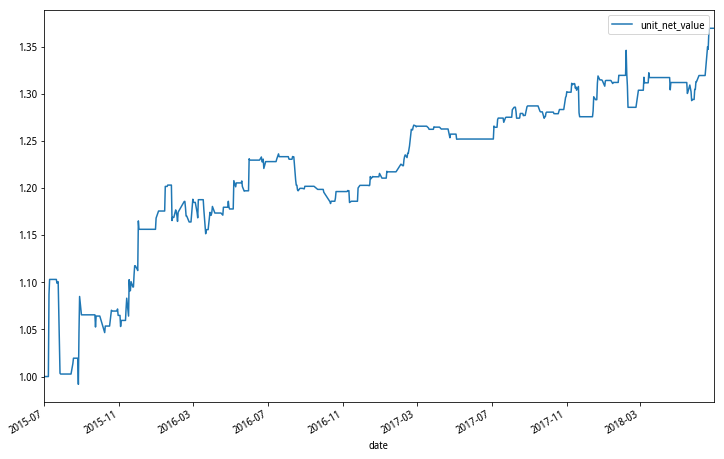

交易品种：IF88
总收益率：36.900000%
年化收益率：11.000000%
最大回撤：10.100000%
夏普比率：0.780
信息比率：0.989
波动率：0.112
跟踪误差：0.112
下行风险：0.069
交易次数：118
胜率：60.200000%
单次平均收益率：0.312712%


In [13]:
analyze_result(result_IF)

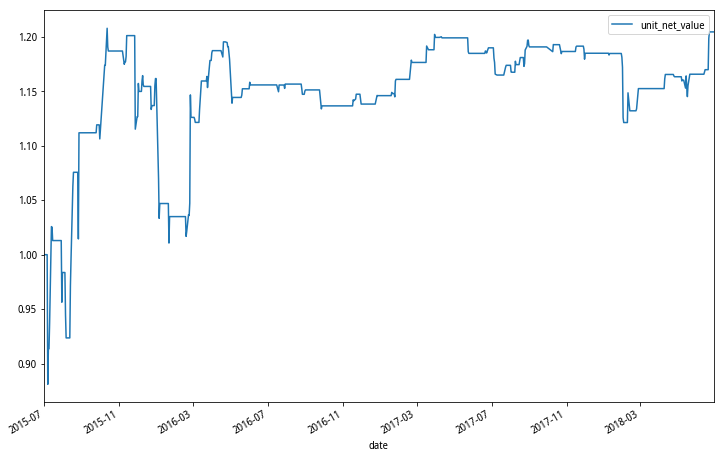

交易品种：IC88
总收益率：20.500000%
年化收益率：6.400000%
最大回撤：16.300000%
夏普比率：0.308
信息比率：0.442
波动率：0.175
跟踪误差：0.175
下行风险：0.119
交易次数：83
胜率：55.400000%
单次平均收益率：0.246988%


In [14]:
analyze_result(result_IC)

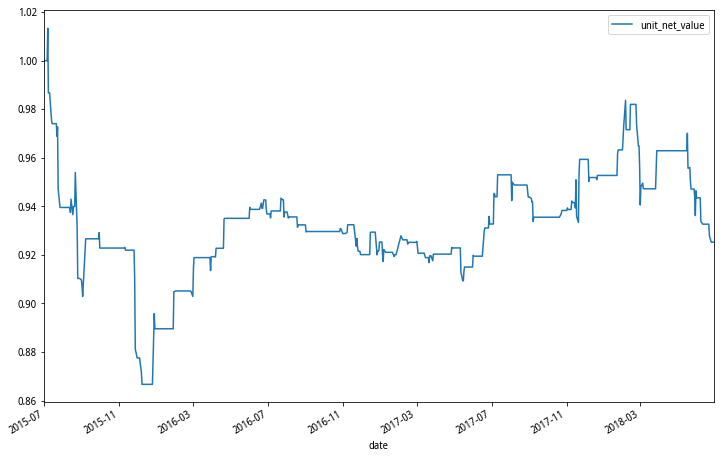

交易品种：IH88
总收益率：-7.500000%
年化收益率：-2.600000%
最大回撤：14.500000%
夏普比率：-0.758
信息比率：-0.382
波动率：0.063
跟踪误差：0.063
下行风险：0.046
交易次数：88
胜率：50.000000%
单次平均收益率：-0.085227%


In [15]:
analyze_result(result_IH)

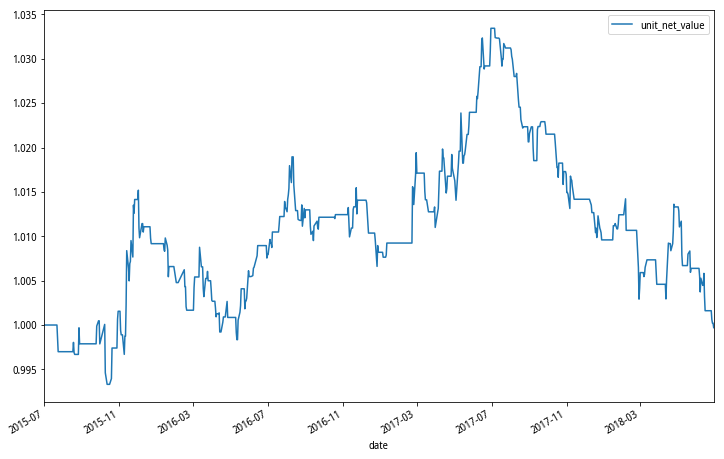

交易品种：T88
总收益率：-0.000000%
年化收益率：-0.000000%
最大回撤：3.300000%
夏普比率：-1.311
信息比率：0.003
波动率：0.018
跟踪误差：0.018
下行风险：0.012
交易次数：149
胜率：49.500000%
单次平均收益率：-0.000000%


In [16]:
analyze_result(result_T)

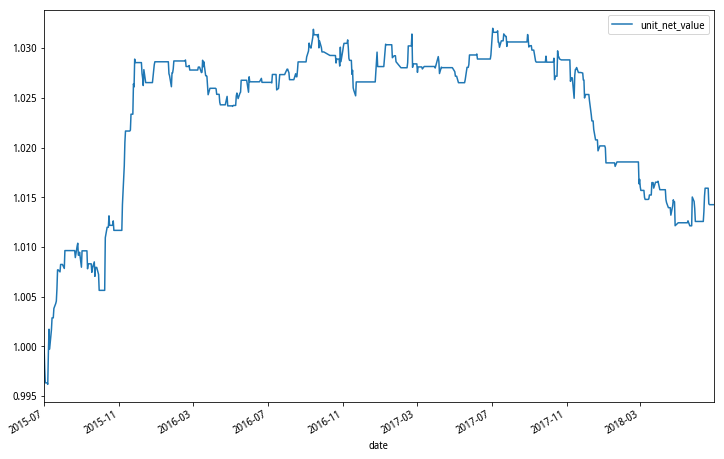

交易品种：TF88
总收益率：1.400000%
年化收益率：0.500000%
最大回撤：1.900000%
夏普比率：-1.796
信息比率：0.457
波动率：0.010
跟踪误差：0.010
下行风险：0.006
交易次数：132
胜率：47.000000%
单次平均收益率：0.010606%


In [17]:
analyze_result(result_TF)

ricequant上的回测结果与研报中有出入，原因在于

1、研报是利用收益率的叠加来得到无杠杆收益率，但在股指期货这些较大价值的合约里，采用固定手数可能更贴近实际。

2、此外回测引擎的逻辑（成本等计算）也有所不同，统计的方法也不同（比如我这里统计的是交易次数而不是信号次数）。

3、数据源不同，不过策略的逻辑是一致的。

从近3年的回测绩效来看，蜘蛛网策略在IF上表现最好。

该策略近年在国债期货上表现一般，原因可能是因为国债期货的行情受利率政策的影响，加上套保盘占比可能较大，因此持仓量数据无法体现市场预期。

同样地，由于商品期货行情多了一个外盘行情的变量影响，因此策略预期在单个品种上波动会不少，研报认为可以通过选择品种构建投资组合的方式，有兴趣可以回测一下。

#### 三、信号的精炼

在早期研报中，作者构建了一些指标进行策略辅助，比如入榜会员总数、持仓量变化绝对值等，不过这类指标需要参数调优，因此有过拟合行情的可能。

在近期的研报中给出了三种信号精炼的比较。

1、周五与非周五信号

在直觉观念上，A股普遍存在日历效应，在本策略中由于周五收盘后发出的信号需要下周一才能进场，中间隔着一个周末，如果周末有影响市场的消息发生，那么市场预期与可能会改变。下面来对IF主力合约上市以来的到20180629的8年行情进行分析。

In [18]:
config_IF = {
  "base": {
    "matching_type": "next_bar",
    "start_date": "2010-04-16", # 回测开始日期
    "end_date": "2018-06-29", # 回测结束日期
    "frequency": '1m', # 回测频率, 分钟: '1m'
    "accounts": {"future":1000000} # 期货账户
  },
  "mod": {
    "sys_progress": {"enabled": True,"show": True,},
    "sys_analyser": {"enabled": True,},
  }
}

In [19]:
# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init_IF_no_friday(context):
    context.df_oir = read_oir_no_friday('IF_oir.xls')
    context.hold = 0
    context.future_id = 'IF88'
    subscribe(context.future_id)
    context.signal = 0
    context.lots = 1

def init_IF_only_friday(context):
    context.df_oir = read_oir_only_friday('IF_oir.xls')
    context.hold = 0
    context.future_id = 'IF88'
    subscribe(context.future_id)
    context.signal = 0
    context.lots = 1
    
# 读取回测用持仓数据，根据数据计算信号
def read_oir_no_friday(filename):
    df = pd.read_excel(filename)
    df = df.sort_values('date',ascending=True)
    df['date'] = df['date'].map(lambda x:x.date())
    df.index = pd.DatetimeIndex(df['date'])
    df.index.name = None
    
    signal = []
    # 1：多头，-1：空头，0：空仓
    for index, row in df.iterrows():
        # 如果是周五，则信号为0
        if row['date'].weekday() == 4:
            signal.append(0)
        else:
            if row['long_position_increase'] > 0 and row['short_position_increase'] < 0:
                signal.append(1)
            elif row['long_position_increase'] < 0 and row['short_position_increase'] > 0:
                signal.append(-1)
            else:
                signal.append(0)
            
    df['signal'] = signal
    return df

# 读取回测用持仓数据，根据数据计算信号
def read_oir_only_friday(filename):
    df = pd.read_excel(filename)
    df = df.sort_values('date',ascending=True)
    df['date'] = df['date'].map(lambda x:x.date())
    df.index = pd.DatetimeIndex(df['date'])
    df.index.name = None
    
    signal = []
    # 1：多头，-1：空头，0：空仓
    for index, row in df.iterrows():
        # 如果不是周五，则信号为0
        if row['date'].weekday() != 4:
            signal.append(0)
        else:
            if row['long_position_increase'] > 0 and row['short_position_increase'] < 0:
                signal.append(1)
            elif row['long_position_increase'] < 0 and row['short_position_increase'] > 0:
                signal.append(-1)
            else:
                signal.append(0)
            
    df['signal'] = signal
    return df

In [20]:
result_IF_all = run_func(init=init_IF, handle_bar=handle_bar, before_trading=before_trading, after_trading=after_trading, config=config_IF)

[2018-07-30 22:45:03.599411] INFO: system_log: rqdatac use socket ('192.168.0.241', 16003)


/opt/conda/envs/ricequant/lib/python3.5/site-packages/rqalpha/utils/risk.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self._beta = cov[0][1] / cov[1][1]


In [21]:
result_IF_no_friday = run_func(init=init_IF_no_friday, handle_bar=handle_bar, before_trading=before_trading, after_trading=after_trading, config=config_IF)

[2018-07-30 22:45:26.633404] INFO: system_log: rqdatac use socket ('192.168.0.241', 16003)


/opt/conda/envs/ricequant/lib/python3.5/site-packages/rqalpha/utils/risk.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self._beta = cov[0][1] / cov[1][1]


In [22]:
result_IF_only_friday = run_func(init=init_IF_only_friday, handle_bar=handle_bar, before_trading=before_trading, after_trading=after_trading, config=config_IF)

[2018-07-30 22:45:47.064047] INFO: system_log: rqdatac use socket ('192.168.0.241', 16003)


/opt/conda/envs/ricequant/lib/python3.5/site-packages/rqalpha/utils/risk.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self._beta = cov[0][1] / cov[1][1]


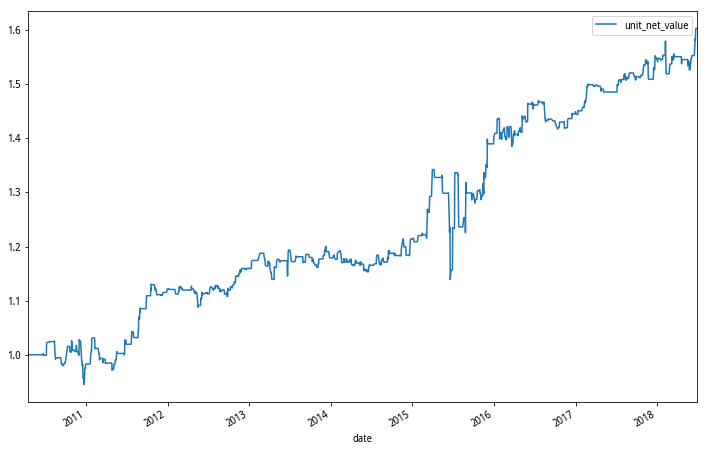

交易品种：IF88
总收益率：60.300000%
年化收益率：5.900000%
最大回撤：15.100000%
夏普比率：0.340
信息比率：0.716
波动率：0.086
跟踪误差：0.086
下行风险：0.054
交易次数：325
胜率：54.800000%
单次平均收益率：0.185538%


In [23]:
analyze_result(result_IF_all)

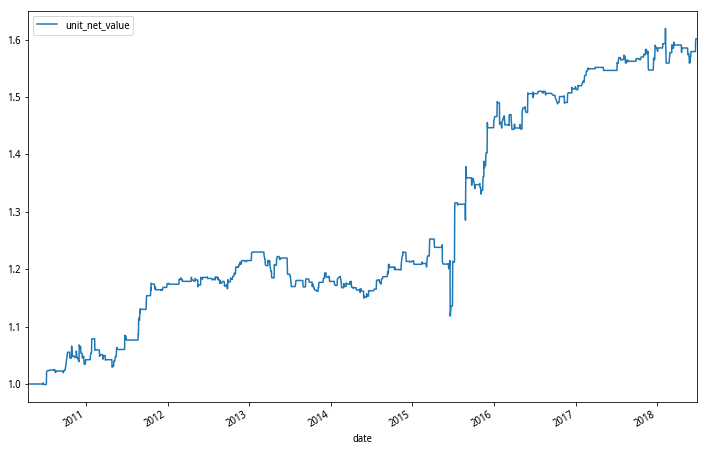

交易品种：IF88
总收益率：60.100000%
年化收益率：5.900000%
最大回撤：10.700000%
夏普比率：0.400
信息比率：0.863
波动率：0.069
跟踪误差：0.069
下行风险：0.040
交易次数：251
胜率：55.000000%
单次平均收益率：0.239442%


In [24]:
analyze_result(result_IF_no_friday)

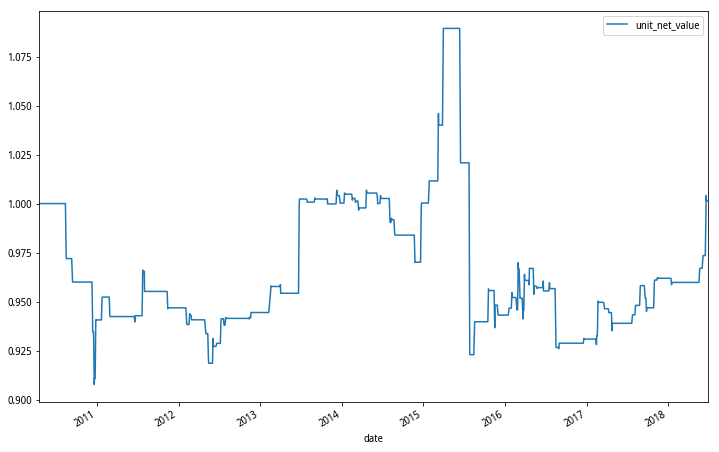

交易品种：IF88
总收益率：0.100000%
年化收益率：0.000000%
最大回撤：15.300000%
夏普比率：-0.508
信息比率：0.033
波动率：0.060
跟踪误差：0.060
下行风险：0.045
交易次数：83
胜率：51.800000%
单次平均收益率：0.001205%


In [25]:
analyze_result(result_IF_only_friday)

从绩效可以看出，非周五信号虽然没有直接提高总收益率，不过单次收益比周五信号更强，与全信号比较亦能提高夏普比率，降低最大回撤。

从回测绩效结果上能验证本策略的日历效应存在。

2、强信号与弱信号

蜘蛛网策略的信号只依赖于持仓量变化的正负符号，在这里提出疑问，如果持仓量变化的绝对值较大时，信号是否比绝对值较少时更有效呢？

为了验证这个猜想，定义多头和空头持仓量变化的绝对值都大于等于100时为强信号，小于100时为弱信号，下面来对比两种信号的绩效。

In [26]:
# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init_IF_strong_signal(context):
    context.df_oir = read_oir_strong_signal('IF_oir.xls')
    context.hold = 0
    context.future_id = 'IF88'
    subscribe(context.future_id)
    context.signal = 0
    context.lots = 1

def init_IF_weak_signal(context):
    context.df_oir = read_oir_weak_signal('IF_oir.xls')
    context.hold = 0
    context.future_id = 'IF88'
    subscribe(context.future_id)
    context.signal = 0
    context.lots = 1
    
# 读取回测用持仓数据，根据数据计算信号
def read_oir_strong_signal(filename):
    df = pd.read_excel(filename)
    df = df.sort_values('date',ascending=True)
    df['date'] = df['date'].map(lambda x:x.date())
    df.index = pd.DatetimeIndex(df['date'])
    df.index.name = None
    
    signal = []
    # 1：多头，-1：空头，0：空仓
    for index, row in df.iterrows():
        if row['long_position_increase'] >= 100 and row['short_position_increase'] <= -100:
            signal.append(1)
        elif row['long_position_increase'] <= -100 and row['short_position_increase'] >= 100:
            signal.append(-1)
        else:
            signal.append(0)
            
    df['signal'] = signal
    return df

# 读取回测用持仓数据，根据数据计算信号
def read_oir_weak_signal(filename):
    df = pd.read_excel(filename)
    df = df.sort_values('date',ascending=True)
    df['date'] = df['date'].map(lambda x:x.date())
    df.index = pd.DatetimeIndex(df['date'])
    df.index.name = None
    
    signal = []
    # 1：多头，-1：空头，0：空仓
    for index, row in df.iterrows():
        if row['long_position_increase'] > 0 and row['short_position_increase'] < 0 \
        and (row['long_position_increase'] < 100 or row['short_position_increase'] > -100):
            signal.append(1)
        elif row['long_position_increase'] < 0 and row['short_position_increase'] > 0 \
        and (row['long_position_increase'] > -100 or row['short_position_increase'] < 100):
            signal.append(-1)
        else:
            signal.append(0)
            
    df['signal'] = signal
    return df

In [27]:
result_IF_strong_signal = run_func(init=init_IF_strong_signal, handle_bar=handle_bar, before_trading=before_trading, after_trading=after_trading, config=config_IF)

[2018-07-30 22:46:05.564267] INFO: system_log: rqdatac use socket ('192.168.0.241', 16003)


/opt/conda/envs/ricequant/lib/python3.5/site-packages/rqalpha/utils/risk.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self._beta = cov[0][1] / cov[1][1]


In [28]:
result_IF_weak_signal = run_func(init=init_IF_weak_signal, handle_bar=handle_bar, before_trading=before_trading, after_trading=after_trading, config=config_IF)

[2018-07-30 22:46:24.307659] INFO: system_log: rqdatac use socket ('192.168.0.241', 16003)


/opt/conda/envs/ricequant/lib/python3.5/site-packages/rqalpha/utils/risk.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self._beta = cov[0][1] / cov[1][1]


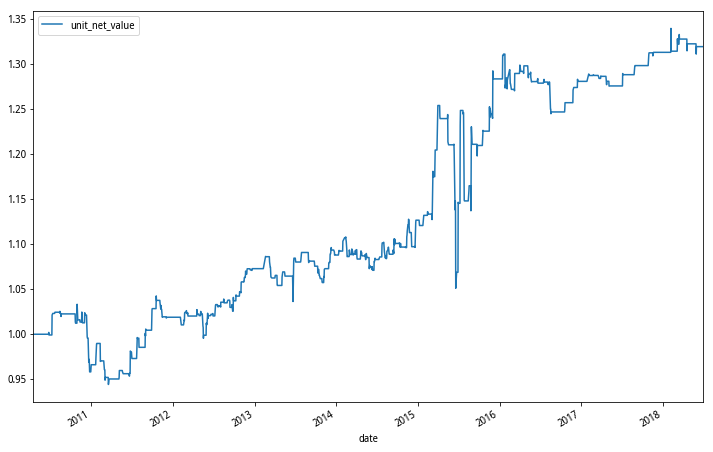

交易品种：IF88
总收益率：31.900000%
年化收益率：3.400000%
最大回撤：16.200000%
夏普比率：0.061
信息比率：0.452
波动率：0.082
跟踪误差：0.082
下行风险：0.053
交易次数：215
胜率：54.000000%
单次平均收益率：0.148372%


In [29]:
analyze_result(result_IF_strong_signal)

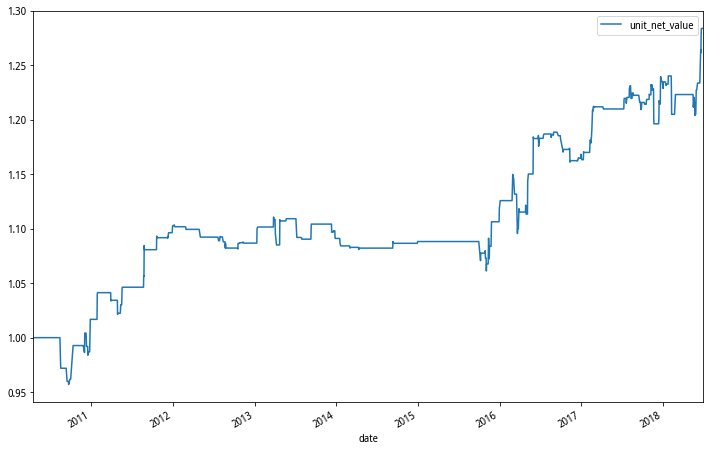

交易品种：IF88
总收益率：28.400000%
年化收益率：3.100000%
最大回撤：4.700000%
夏普比率：-0.018
信息比率：0.743
波动率：0.042
跟踪误差：0.042
下行风险：0.024
交易次数：117
胜率：55.600000%
单次平均收益率：0.242735%


In [30]:
analyze_result(result_IF_weak_signal)

从绩效结果来看，无法得出强信号优于弱信号的结论。

原因很可能是弱信号过滤了15年股灾的行情，而强信号在股指受限后，发出的信号并不多。

3、顺势和逆势

市场行情往往会有一定的短期趋势，那么可以提出猜想，如果行情的涨跌方向与策略的信号方向一致，是否有更强的效益呢。

假设策略信号为1时且当天close>open，称为顺势信号，反之则为逆势信号。

In [31]:
# after_trading函数会在每天交易结束后被调用，当天只会被调用一次
def after_trading_trend(context):
    # 每天收盘获取信号，在下一个交易日使用
    trade_date = context.now.date()
    context.signal = context.df_oir[context.df_oir['date'] == trade_date].signal.values[0]
    
    df = history_bars(context.future_id, bar_count=1, frequency='1d', fields=['open', 'close'], include_now = True)
    if context.signal == 1 and df[0][1] < df[0][0]:
        context.signal = 0
    if context.signal == -1 and df[0][0] < df[0][1]:
        context.signal = 0
        
def after_trading_reverse_trend(context):
    # 每天收盘获取信号，在下一个交易日使用
    trade_date = context.now.date()
    context.signal = context.df_oir[context.df_oir['date'] == trade_date].signal.values[0]
    
    df = history_bars(context.future_id, bar_count=1, frequency='1d', fields=['open', 'close'], include_now = True)
    if context.signal == 1 and df[0][1] >= df[0][0]:
        context.signal = 0
    if context.signal == -1 and df[0][0] >= df[0][1]:
        context.signal = 0

In [32]:
result_IF_trend = run_func(init=init_IF, handle_bar=handle_bar, before_trading=before_trading, after_trading=after_trading_trend, config=config_IF)

[2018-07-30 22:46:43.371935] INFO: system_log: rqdatac use socket ('192.168.0.241', 16003)


/opt/conda/envs/ricequant/lib/python3.5/site-packages/rqalpha/utils/risk.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self._beta = cov[0][1] / cov[1][1]


In [33]:
result_IF_reverse_trend = run_func(init=init_IF, handle_bar=handle_bar, before_trading=before_trading, after_trading=after_trading_reverse_trend, config=config_IF)

[2018-07-30 22:47:02.230205] INFO: system_log: rqdatac use socket ('192.168.0.241', 16003)


/opt/conda/envs/ricequant/lib/python3.5/site-packages/rqalpha/utils/risk.py:121: RuntimeWarning: invalid value encountered in double_scalars
  self._beta = cov[0][1] / cov[1][1]


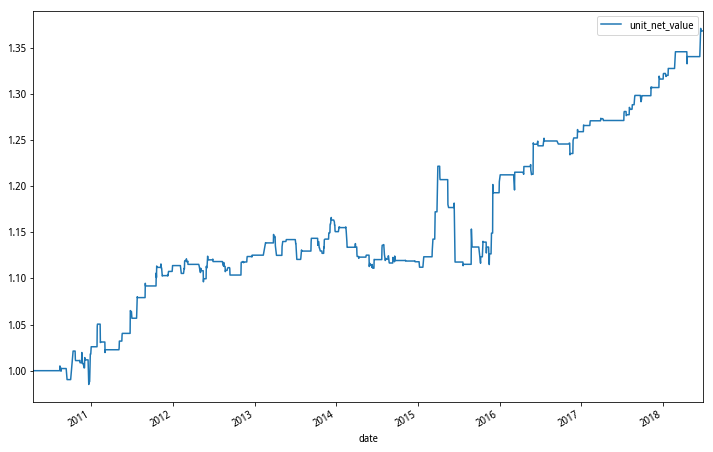

交易品种：IF88
总收益率：36.800000%
年化收益率：3.900000%
最大回撤：8.800000%
夏普比率：0.147
信息比率：0.791
波动率：0.050
跟踪误差：0.050
下行风险：0.029
交易次数：148
胜率：53.400000%
单次平均收益率：0.248649%


In [34]:
analyze_result(result_IF_trend)

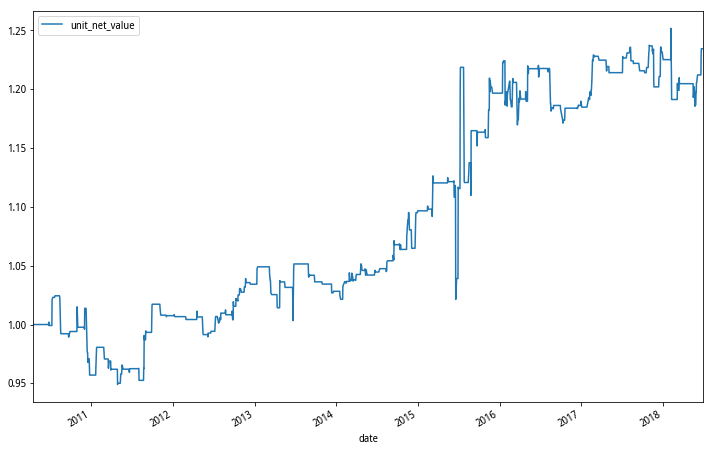

交易品种：IF88
总收益率：23.400000%
年化收益率：2.600000%
最大回撤：9.300000%
夏普比率：-0.043
信息比率：0.367
波动率：0.079
跟踪误差：0.079
下行风险：0.052
交易次数：186
胜率：56.500000%
单次平均收益率：0.125806%


In [35]:
analyze_result(result_IF_reverse_trend)

从绩效结果可以看出，虽然顺势信号的单次收益显著提高，但逆势信号的收益率尚可，在交易次数上逆势信号比顺势信号更多一点。

如果要综合考虑总收益的话，由于蜘蛛网策略是一个低频策略（一年大概40次），那么逆势信号在策略中依然有一席之地。

从三个猜想的验证来看，利用非周五来精炼信号的效果最好，原因可能是该猜想的逻辑（A股的日历效应）较强。

#### 四、结论

我们验证了蜘蛛网策略在金融期货上的IF品种绩效最好，同时我们也验证了信号精炼的猜想有效性，在有必要时可对策略进行精炼。

蜘蛛网策略是一个不需要任何参数的策略，有很好的普适性，因此添加太多的限制条件反而无法体现策略的基本思路。研报中还提及到了策略在商品期货上的可行性以及持仓时间对绩效的影响，在后续的工作中可以对这两方面进行验证。从策略构思来看，持仓数据变化的信号体现的是聪明投资者对市场的反应，因此若某些品种聪明投资者比例较少（比如外盘影响较多的商品期货和套保盘较多的期货品种），此策略的预测能力将会降低。